In [1]:
from sklearn.datasets import load_diabetes
import seaborn as sns

sns.set_theme(style="whitegrid")
diabetes = load_diabetes(as_frame=True, scaled=False)

In [2]:
from scipy.stats import pearsonr, spearmanr, kendalltau
from matplotlib import pyplot as plt
import pandas
from typing import List
import numpy


def eyeball_test(xx: str, yy: str, data: pandas.DataFrame) -> None:
    """
    Plot a scatterplot and print correlation statistics between two variables.

    Args:
        xx: Name of first variable in data
        yy: Name of second variable in data
        data: DataFrame containing the variables
    """
    print(pearsonr(data[xx], data[yy]))
    print(spearmanr(data[xx], data[yy]))
    print(kendalltau(data[xx], data[yy]))
    sns.regplot(x=xx, y=yy, data=data)
    plt.show()


def residualize(Z: List[str], yy: str, data: pandas.DataFrame) -> numpy.ndarray:
    """
    Calculate residuals after regressing yy on Z.

    Args:
        Z: List of variable names to use as predictors
        yy: Name of target variable
        data: DataFrame containing all variables

    Returns:
        Residuals from the regression
    """
    X_mat = data[Z].values
    y_vec = data[yy].values
    y_pred = X_mat @ numpy.linalg.lstsq(X_mat, y_vec, rcond=None)[0]
    res_y_x = y_vec - y_pred
    return res_y_x


def eyeball_test_confounders(
    xx: str, yy: str, Z: List[str], X: pandas.DataFrame
) -> None:
    """
    Plot relationship between two variables after controlling for confounders.

    Args:
        xx: Name of first variable
        yy: Name of second variable
        Z: List of confounder variable names
        X: DataFrame containing all variables
    """
    res1 = residualize(Z, xx, X)
    res2 = residualize(Z, yy, X)

    print(pearsonr(res1, res2))
    sns.regplot(x=res1, y=res2)
    plt.show()

In [3]:
df = diabetes.frame
df["target"] = diabetes.target

In [4]:
from magpy.oracles.oracles import BaseOracle, linear, cubic


oracle = BaseOracle(df, learner=linear)

## Is age a causal factor in diabetes?

To ask whether age is related to diabetes, let's first do a correlation analysis:


PearsonRResult(statistic=0.18788875071891983, pvalue=7.055686149116364e-05)
SignificanceResult(statistic=0.19782187832853038, pvalue=2.8061321217515732e-05)
SignificanceResult(statistic=0.13070890180007, pvalue=4.9982161197476533e-05)


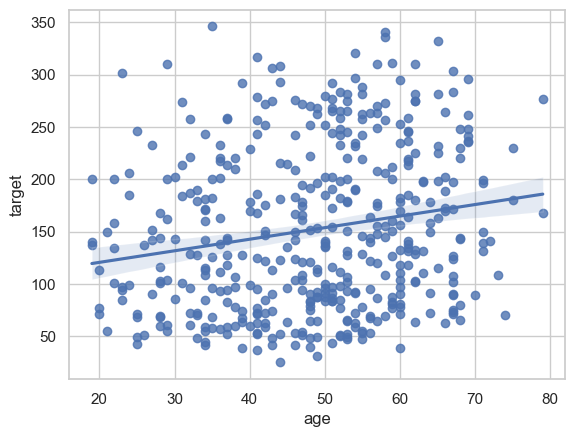

In [5]:
eyeball_test("age", "target", df)

Looks like it's significant. Or is it?

Well suppose that in the population, age increases blood pressure and BMI.


PearsonRResult(statistic=0.18508466614655547, pvalue=9.076791865417418e-05)
SignificanceResult(statistic=0.20055350591938131, pvalue=2.1598700354555388e-05)
SignificanceResult(statistic=0.13653470883401506, pvalue=2.3242597041281745e-05)


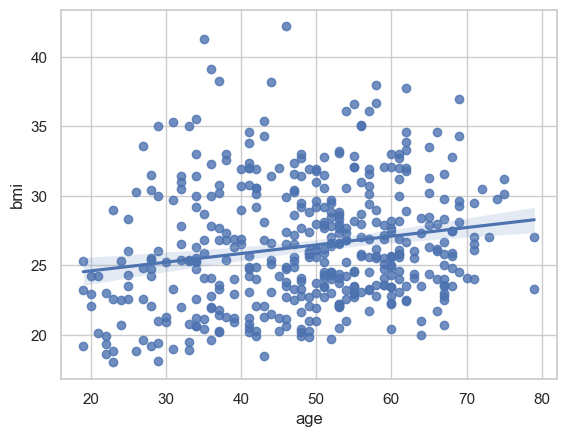

In [6]:
eyeball_test("age", "bmi", df)

And how would BMI and blood pressure affect diabetes?


PearsonRResult(statistic=0.5864501344746887, pvalue=3.466006445167151e-42)
SignificanceResult(statistic=0.5613820101065616, pvalue=4.567023927725032e-38)
SignificanceResult(statistic=0.39119525733058874, pvalue=2.240475743694334e-34)


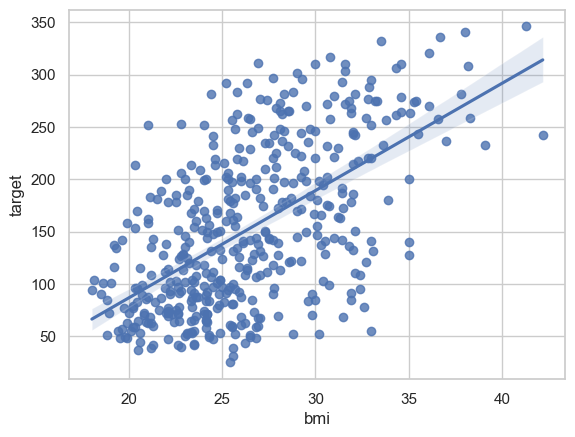

PearsonRResult(statistic=0.44148175856257116, pvalue=1.6493720527427366e-22)
SignificanceResult(statistic=0.4162408981534321, pvalue=5.992783653793123e-20)
SignificanceResult(statistic=0.289351866850984, pvalue=2.4901462749982e-19)


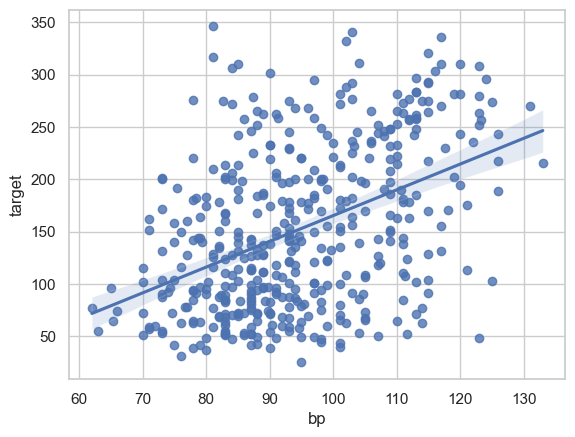

In [7]:
eyeball_test("bmi", "target", df)
eyeball_test("bp", "target", df)

So what if we control for BMI and blood pressure?

The eyball test shows the relationship between:

- The residuals of X given the controls Z, versus
- The residuals of Y given the controls Z.

It gives a visual representation of the _residual effect_ of removing the confounders Z from both X and Y.

To make this more quantitative, we can use our oracle to test the hypothesis that X and Y are still associated, given Z.


PearsonRResult(statistic=-0.046455547215157204, pvalue=0.3298418724518599)


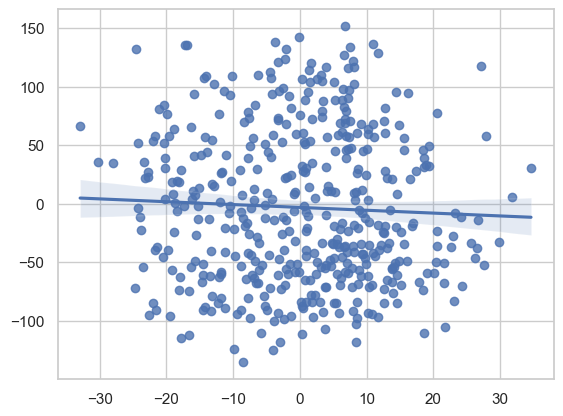

In [8]:
eyeball_test_confounders("age", "target", ["bp", "bmi"], df)

In [9]:
print("Independdent: ", oracle("age", "target", ["bp", "bmi"]))
print("pvalue: ", oracle._run("age", "target", ["bp", "bmi"]))

Independdent:  True
pvalue:  0.684506181045349


Well what a surprise, it looks like age is not related to diabetes after controlling for BP and BMI.

But that begs the question, why does the correlation exists?

As humans we understand that the likely scenario is:

Age -> BP / BMI -> Diabetes

But how could we discover that systematically from the data?


## Building a skeleton

So let's say we make this analysis systematic:

Is age associated with diabetes?
Is age associated with blood pressure?
Is blood pressure associated with diabetes?
Is age associated with diabetes, conditional no blood pressure?
....

By repeating this process iteratively, we can in theory build a skeleton of all possible variables that may be causally related to each other.

This is the idea behind the PC Skeleton algorithm.

Let's see how it works:


In [10]:
from magpy.search.pcskeleton import pc_skeleton

df_std = (df - df.mean()) / df.std()
oracle = BaseOracle(df_std, learner=linear, threshold=0.1)
skeleton, sepsets = pc_skeleton(oracle, df_std.columns)

/Users/andre/CDL2024/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
skeleton

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
sex,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
bmi,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
bp,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
s1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
s2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
s3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
s4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
s5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
s6,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


We have an adjacency matrix, as well as an object called **sepsets**, which contains the conditioning set that were used to _separate_ the two variables.

For instance, why is age not related to diabetes? Because they were separated by controlling for ...


In [12]:
sepsets[("age", "target")]

('s5',)

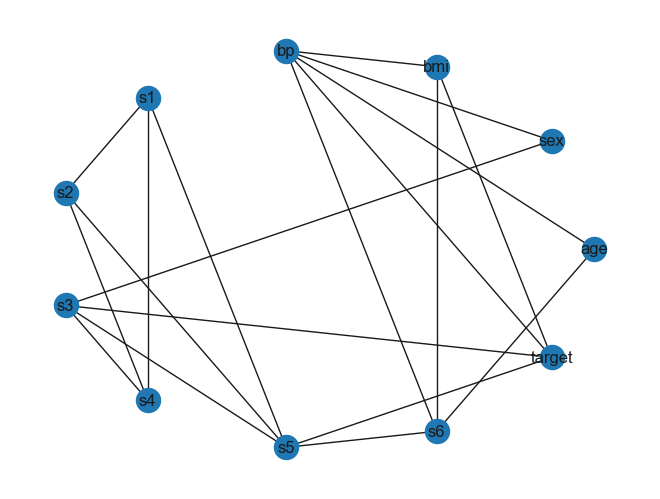

In [13]:
import networkx as nx

g = nx.from_pandas_adjacency(skeleton)
nx.draw_circular(g, with_labels=True)
plt.show()

## Orientation

There are many many ways to build orientations from a graph. I won't dwell too much on this, but let's just use one method (exact search) to see how it works.

This method relies on a way to score the quality of a graph (in this case by lowering the BIC score of all the relationships).

What is the BIC score, if you ask me: it measures the likelihood of the data given the model.

The BIC score is defined as:

$$ BIC = -2 \log(L) + k \log(n) $$

where L is the likelihood of the data given the model, k is the number of parameters in the model, and n is the number of observations.

Keeping in mind that causal discovery is not a perfect science - there are many many ways of creating good graphs given the data, but only one them represents reality. But it's a good start!

In order to discover a graph, we can start from two points:

1. The skeleton
2. A set of include edges

The skeleton is the "undrected" graph which we just discovered.

The include edges are the edges we want to include in the graph. For instance, if we know that Age cannot be a "child" node, we can force it to be a parent of other nodes that are related to it.


In [14]:
include_graph = pandas.DataFrame(0, columns=df_std.columns, index=df_std.columns)

include_graph.loc["age", "bp"] = 1
include_graph.loc["age", "s6"] = 1
include_graph.loc["bmi", "target"] = 1
include_graph.loc["bp", "target"] = 1
include_graph.loc["s3", "target"] = 1
include_graph.loc["bmi", "bp"] = 1
include_graph.loc["sex", "s3"] = 1
include_graph.loc["sex", "bp"] = 1

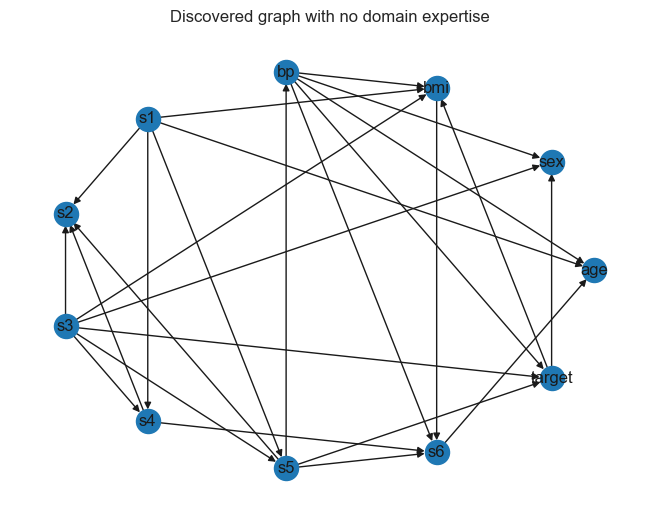

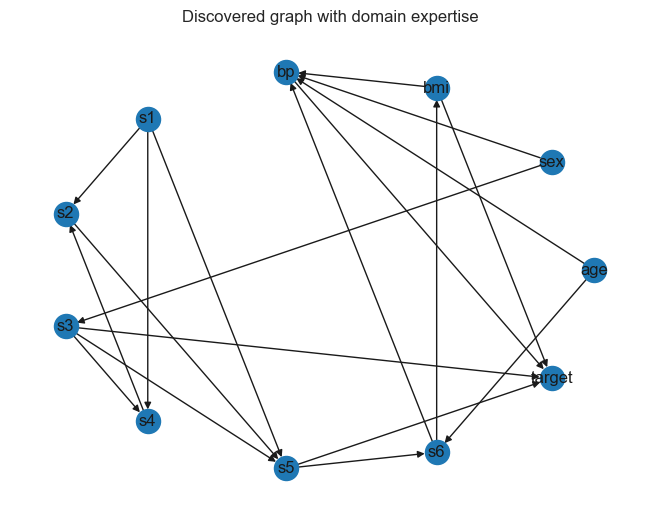

In [15]:
from magpy.search.astar import AStarSearch, bic_score_node

# discovered graph with no domain expertise
astar = AStarSearch(df_std)
astar.run_scoring(parallel=False, func=bic_score_node)
mat = astar.search()

g = nx.from_pandas_adjacency(mat, create_using=nx.DiGraph)
nx.draw_circular(g, with_labels=True)
plt.title("Discovered graph with no domain expertise")
plt.show()


# discovered graph with domain expertise
astar = AStarSearch(df_std, super_graph=skeleton, include_graph=include_graph)
astar.run_scoring(parallel=False, func=bic_score_node)
mat = astar.search()

g = nx.from_pandas_adjacency(mat, create_using=nx.DiGraph)
nx.draw_circular(g, with_labels=True)
plt.title("Discovered graph with domain expertise")
plt.show()

## doWhy and interventions

So what will happen if we increase or decrease a variable? After all, this is what we want to know!

So the idea behind a structural causal model is precisely to answer such questions. Unlike a ML model, an SCM requires a prior in the form of a causal graph, and then lets us simulate the effect of interventions.


In [16]:
from dowhy import gcm

causal_model = gcm.StructuralCausalModel(g)
assignment = gcm.auto.assign_causal_mechanisms(causal_model, df)
gcm.fit(causal_model, df)

Fitting causal mechanism of node target: 100%|██████████| 11/11 [00:00<00:00, 101.27it/s]


In [17]:
def get_effect_distribution(causal_model, change_var, change=1):
    r = []
    for n in range(100):
        samples = gcm.interventional_samples(
            causal_model, {change_var: lambda x: x + change}, num_samples_to_draw=100
        )
        vals = samples.mean()
        r.append(vals.to_dict())

    dist_df = pandas.DataFrame(r)
    return dist_df

In [18]:
intervention_var = "s3"
intervention_value = 2 * df[intervention_var].std()


interventional_data = get_effect_distribution(
    causal_model, intervention_var, intervention_value
)
average_effects = interventional_data - df.mean()

rdf = pandas.DataFrame({"mean": average_effects.mean()})
rdf["t"] = rdf["mean"] / df.std()

rdf.round(2)

,mean,t
age,0.03,0.00
bmi,-1.11,-0.25
bp,-2.72,-0.20
s1,0.59,0.02
s2,-11.80,-0.39
s3,25.71,1.99
s4,-1.39,-1.08
s5,-0.81,-1.55
s6,-7.54,-0.66
sex,0.01,0.01


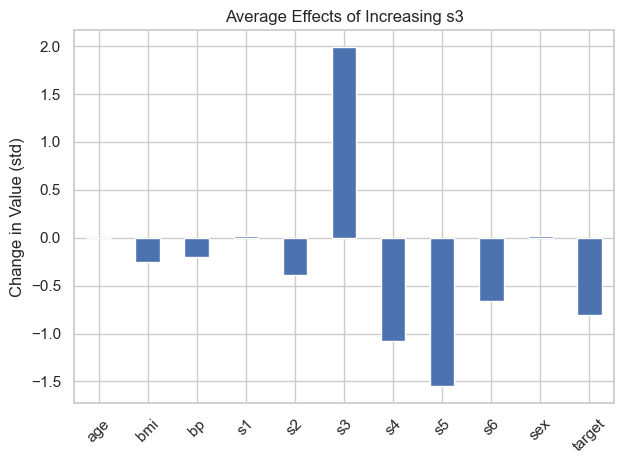

In [19]:
rdf["t"].plot(kind="bar")
plt.xticks(rotation=45)
plt.title(f"Average Effects of Increasing {intervention_var}")
plt.ylabel("Change in Value (std)")
plt.tight_layout()

Text(0, 0.5, 'Density')

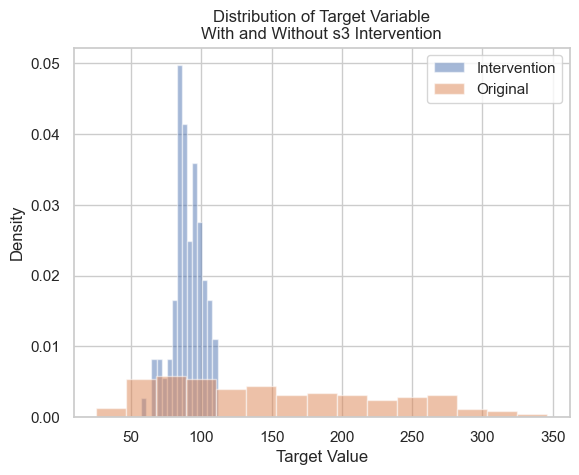

In [20]:
plt.figure()
plt.hist(
    interventional_data["target"],
    alpha=0.5,
    label="Intervention",
    bins=15,
    density=True,
)
plt.hist(df["target"], alpha=0.5, label="Original", bins=15, density=True)
plt.legend()
plt.title(
    f"Distribution of Target Variable\nWith and Without {intervention_var} Intervention"
)
plt.xlabel("Target Value")
plt.ylabel("Density")

In [21]:
from sklearn.linear_model import LinearRegression


features = [x for x in df.columns if x != "target"]
lr = LinearRegression()
lr.fit(df[features], df["target"])
{x: y for x, y in zip(features, lr.coef_)}

{'age': -0.03636122422361796,
 'sex': -22.85964809049841,
 'bmi': 5.602962091923703,
 'bp': 1.116807993318191,
 's1': -1.0899963340632297,
 's2': 0.7464504555142106,
 's3': 0.37200471508913613,
 's4': 6.533831935990324,
 's5': 68.48312496478829,
 's6': 0.2801169893214963}

In [22]:
# Get the standard deviation of s3
s3_std = df["s3"].std()

# Calculate the impact using linear regression coefficient
s3_coef = lr.coef_[features.index("s3")]
impact = s3_coef * (2 * s3_std)

increase_or_decrease = "increase" if s3_coef > 0 else "decrease"

print(
    f"According to linear regression, changing s3 by {2*s3_std:.2f} units (2 std devs)"
)
print(
    f"would {increase_or_decrease} the target by {impact:.2f} units, or {impact/df['target'].std():.2f} std devs"
)

According to linear regression, changing s3 by 25.87 units (2 std devs)
would increase the target by 9.62 units, or 0.12 std devs
